# Wiener FIR Filter

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import scipy

In [ ]:
n = 2500
data_type = np.float32
t = np.linspace(0, 1, n, dtype=data_type)

# Filter class

In [ ]:
class Wiener_FIR:
    def __init__(self, order=1, solver=np.linalg.solve, correlation_method='auto'):
        """
        order - The order of the filter
        solver - A linear system solver (callable). An iterative method is probably preferable to a direct one for extremely large systems (i.e. large values of N)
        correlation_method - {'auto', 'direct', 'fft'}
        """
        self.order = order
        self.solver = solver
        self.correlation_method = correlation_method

    def fit(self, x, y):
        """
        Calculates R_xx, R_xy and solves the system R_xx.w = R_xy, where:
        x - Input time discrete signal
        y - Reference time discrete signal
        R_xx - Autocorrelation matrix (which is also a Toeplitz and an Hermitian matrix)
        R_xy - Cross-correlation vector
        """
        x, y, signal_length = x.ravel(), y.ravel(), x.size

        R_xx = np.flip(scipy.signal.correlate(x, x, 'full', self.correlation_method)[:signal_length])[:self.order]/signal_length # R_xx[m] = E(x[n]x[n+m])
        R_xy = np.flip(scipy.signal.correlate(x, y, 'full', self.correlation_method)[:signal_length])[:self.order]/signal_length # R_xy[m] = E(x[n]y[n+m])

        R_xx[0] = np.real(R_xx[0]) # Imag(R_xx[0]) will always be zero. I'm just adding redundancy against a possible numerical instability (e.g. Real(R_xx[0]) != 0 due to correlation being calculated using FFT)
        R_xx = scipy.linalg.toeplitz(R_xx) # builds the Toeplitz matrix
        self.coefficients = np.conjugate(self.solver(R_xx, R_xy)) # solves the linear system conj(w) = R_xx^(-1).R_xy

    def transform(self, x, ref=None):
        """
        x - Input time discrete signal
        ref - Reference time discrete signal. If ref is not None, ref[n] - x[n] is returned
        """
        input_shape = x.shape
        x, y = x.ravel(), np.zeros(shape=(x.size,), dtype=x.dtype)

        for i in range(self.order):
            if i == 0: y += self.coefficients[i]*x # w[i]x[n-i], i = 0
            else: y[i:] += self.coefficients[i]*x[:-i] # w[i]x[n-i]

        if ref is not None:
            y *= -1
            y += ref.ravel()
        return y.reshape(input_shape)

# Sinusoidal curve filtering

In [ ]:
signal1 = np.sin(2*np.pi*t*10) # target signal
signal2 = np.sin(2*np.pi*t*10 + np.pi/2) # target signal in a different moment in time

noise = np.sin(2*np.pi*t*60)/2 + np.random.default_rng(42).normal(0,.2,t.size) # time-invariant noise

noisy_signal1 = signal1 + noise # noisy observation #1
noisy_signal2 = signal2 + noise # noisy observation #2

In [ ]:
sine_filter = Wiener_FIR(101) # 100th order filter
sine_filter.fit(noisy_signal1, signal1) # learning signal1 from a noisy observation of it (i.e. learning how to reverse the environment's impulse response)
filtered_wfm2 = sine_filter.transform(noisy_signal2) # filtering a different signal

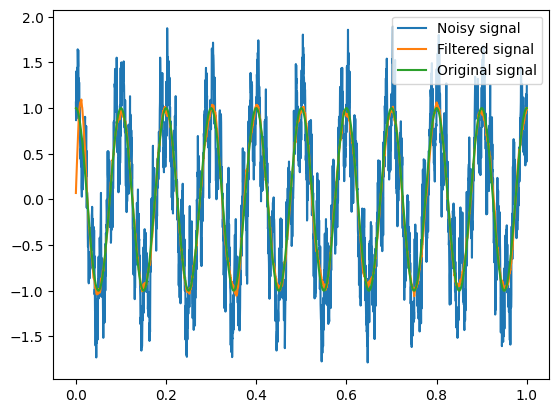

In [ ]:
plt.plot(t, noisy_signal2, label='Noisy signal')
plt.plot(t, filtered_wfm2, label='Filtered signal')
plt.plot(t, signal2, label='Original signal')

plt.legend(loc='best')
plt.show()

## As an adaptive filter

In [ ]:
signal1 = np.sin(2*np.pi*t*10) # target signal

noise1 = np.sin(2*np.pi*t*60) + np.random.default_rng(42).normal(0,.2,t.size) # noise at point A, reference noise
noise2 = np.sin(2*np.pi*t*60+np.pi/3)/2 + np.random.default_rng(42).normal(0,.2,t.size) # noise at point B

noisy_signal1 = signal1 + noise2 # noisy observation at point B

In [ ]:
sine_filter = Wiener_FIR(100) # 100th order filter
sine_filter.fit(noise1, noisy_signal1)
filtered_wfm2 = sine_filter.transform(noise1, ref=noisy_signal1)

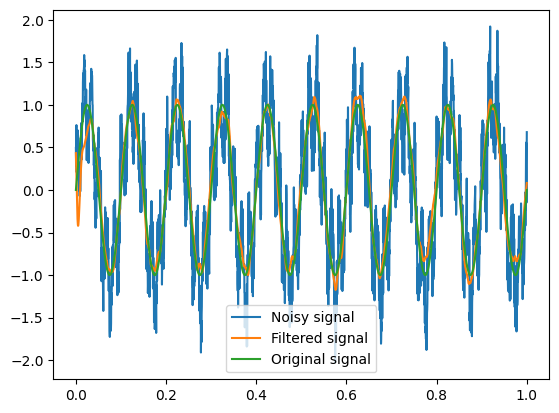

In [ ]:
plt.plot(t, noisy_signal1, label='Noisy signal')
plt.plot(t, filtered_wfm2, label='Filtered signal')
plt.plot(t, signal1, label='Original signal')

plt.legend(loc='best')
plt.show()

## Testing the filter with complex signals

In [ ]:
def C_to_R(x): return np.abs(x)*np.cos(np.angle(x))

In [ ]:
signal1 = np.exp(1j*2*np.pi*t*10) # target signal
signal2 = np.exp(1j*(2*np.pi*t*10 + np.pi)) # target signal in a different moment in time

noise = np.exp(1j*(2*np.pi*t*60)) + np.random.default_rng(42).normal(0,.3,t.size) + 1j*np.random.default_rng(51).normal(0,.3,t.size) # time-invariant noise

noisy_signal1 = signal1*np.exp(np.log(0.7) + 1j*np.pi) + noise # noisy observation #1: signal rotation and dilation + gaussian noise and 60Hz contamination
noisy_signal2 = signal2*np.exp(np.log(0.7) + 1j*np.pi) + noise # noisy observation #2: signal rotation and dilation + gaussian noise and 60Hz contamination

In [ ]:
sine_filter = Wiener_FIR(500) # 500th order filter
sine_filter.fit(noisy_signal1, signal1) # learning signal1 from a noisy observation of it

In [ ]:
filtered_wfm2 = sine_filter.transform(noisy_signal2,)

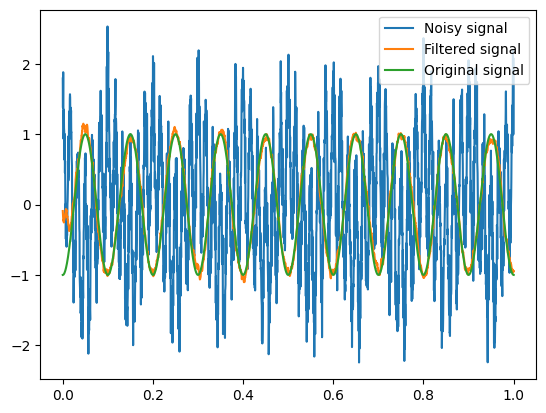

In [ ]:
plt.plot(t, C_to_R(noisy_signal2), label='Noisy signal')
plt.plot(t, C_to_R(filtered_wfm2), label='Filtered signal')
plt.plot(t, C_to_R(signal2), label='Original signal')

plt.legend(loc='best')
plt.show()

# Denoising an image

In [ ]:
def min_max(arr, range=(0,1)):
    arr, min_val, max_val = arr.copy(), arr.min(), arr.max()
    arr -= min_val
    arr /= max_val - min_val
    arr *= range[1] - range[0]
    arr += range[0]
    return arr

In [ ]:
oxford_pets, info = tfds.load('oxford_iiit_pet', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete5ENGWB/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete5ENGWB/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
image = oxford_pets['train'].take(1).get_single_element()['image'].numpy().astype(data_type)
gaussian_noise = np.random.default_rng(42).normal(0, 1, size=image.shape).astype(data_type)*20
noisy_image = image + gaussian_noise

In [ ]:
image_filter = Wiener_FIR(100) # 100th order filter
image_filter.fit(noisy_image, image)
filtered_image = image_filter.transform(noisy_image,) # filtered signal

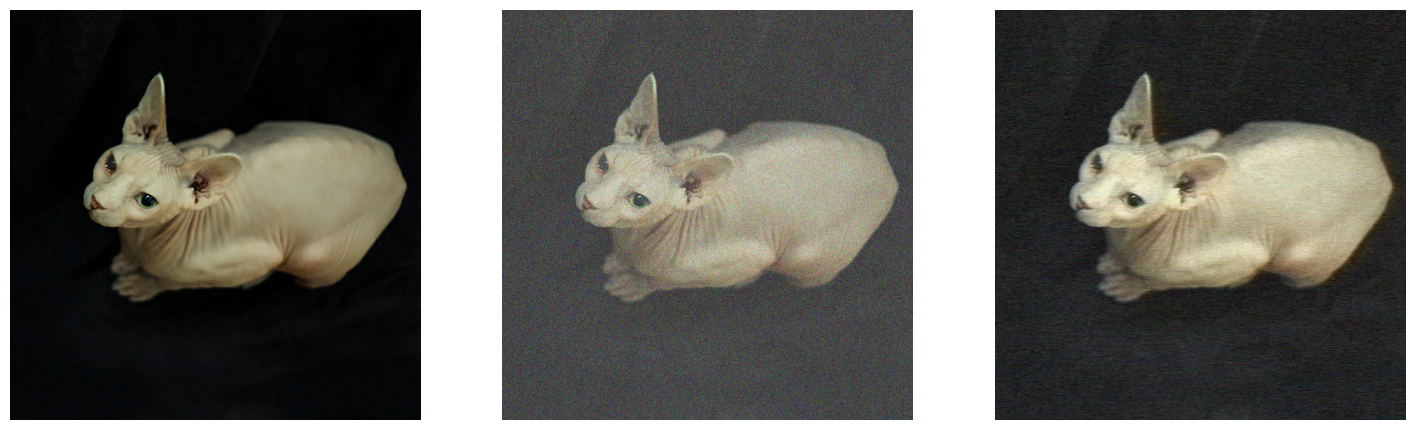

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18,6))

ax[0].imshow(min_max(image))
ax[1].imshow(min_max(noisy_image))
ax[2].imshow(min_max(filtered_image))

for i in range(ax.size):
    ax.ravel()[i].axis('off')

plt.show()

In [ ]:
unseen_image = oxford_pets['test'].take(1).get_single_element()['image'].numpy().astype(data_type)
unseen_noise = np.random.default_rng(42).normal(0, 1, size=unseen_image.shape).astype(data_type)*20.
unseen_noisy_image = unseen_image + unseen_noise

In [ ]:
new_filtered_image = image_filter.transform(unseen_noisy_image,)

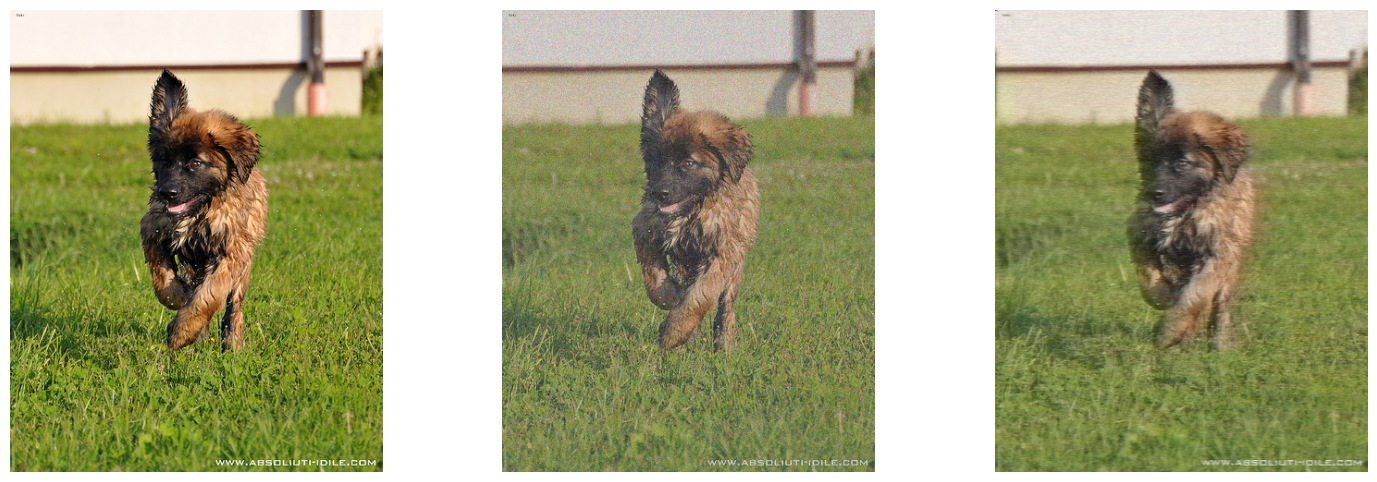

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18,6))

ax[0].imshow(min_max(unseen_image))
ax[1].imshow(min_max(unseen_noisy_image))
ax[2].imshow(min_max(new_filtered_image))

for i in range(ax.size):
    ax.ravel()[i].axis('off')

plt.show()